# Notebook para producción del modelo

El objetivo es realizar la limpieza, ingenieria de caracteristicas y predicciones del modelo asi como su optimizacion para entrenar unicamente las variables para despliegue web con flask

### Carga de data frame
- Cargar el data frame y se actualizan los nulos como 'NaN' para mejor manejo.

In [38]:
# Importo las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
#from sklearn.metrics import plot_roc_curve
import numpy as np


# Importaciones necesarias para Optuna
import optuna
import xgboost as xgb
# Importamos la visualización específica de Plotly
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice

df = pd.read_csv("../data/raw/diabetic_data.csv", na_values="?")

C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\2183819295.py:23: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/diabetic_data.csv", na_values="?")


### Limpieza de datos.
- Se agrupa la variable objetivo `readmitted`, en 2 categorias (0, 1). y se cambia el nombre a `target`.
- Se seleccionan unicamente las caracteristicas que el modelo xgboost detecto como mas relevantes.

C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\3384459661.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


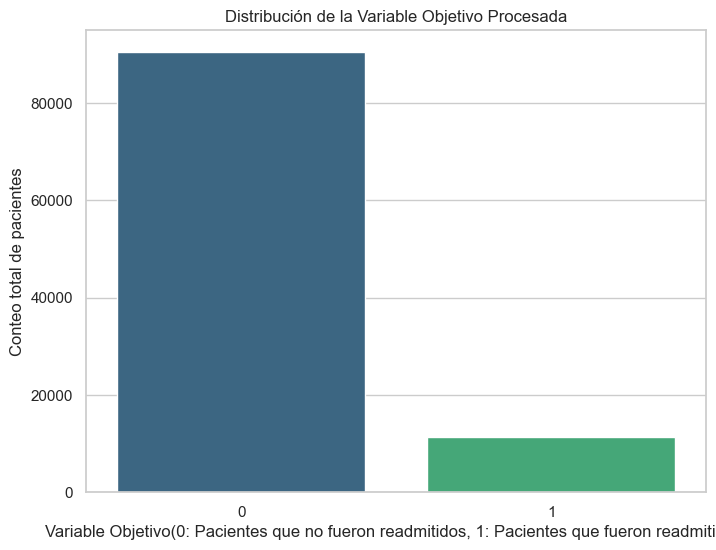

In [39]:
# Definir Target: Readmitted < 30 days (Clase Positiva = 1)
# Esta es la clase minoritaria y la más importante para la salud
df['target'] = (df['readmitted'] == '<30').astype(int)
    

plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribución de la Variable Objetivo Procesada')
plt.xlabel('Variable Objetivo(0: Pacientes que no fueron readmitidos, 1: Pacientes que fueron readmitidos)')
plt.ylabel('Conteo total de pacientes')
plt.show()
df.drop(columns=['readmitted'], inplace=True)

In [40]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'target'],
      dtype='object')

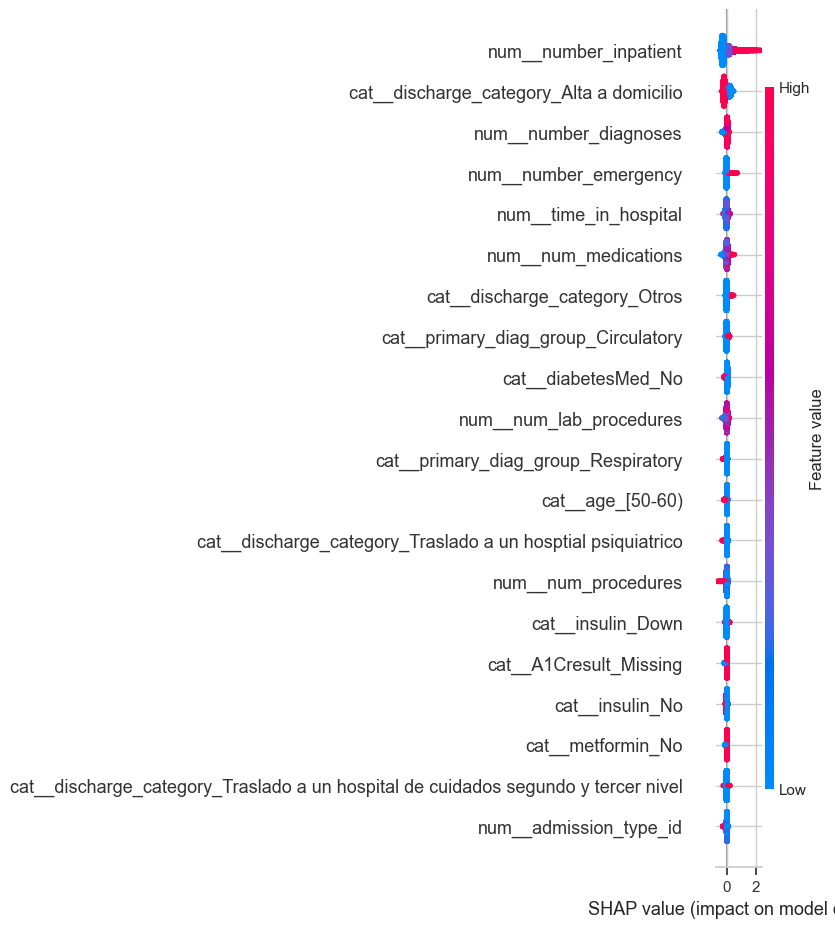

#### Caracteristicas más importantes
- Estas caracteristicas se obtuvieron mediante el calculo del SHAP.

In [41]:
# Caracteristicas mas relevantes para entrenar el modelo
# Estan ordenadas en forma descendente
features = {
    'number_inpatient', # Numero de veces que el paciente ha sido hospitalizado
    'discharge_disposition_id', # Id de la disposicion del paciente al ser dado de alta
    'number_diagnoses', # Numero de diagnósticos
    'number_emergency', # Numero de emergencias
    'time_in_hospital', # Tiempo que el paciente estuvo hospitalizado
    'num_medications', # Numero de medicamentos
    'diag_1', # Diagnostico principal
    'diabetesMed', # Medicamento para diabetes (Si o No)
    'num_lab_procedures', # Numero de procedimientos de laboratorio
    'age', # Edad del paciente
    'num_procedures', # Numero de procedimientos que se le realizaron
    'insulin', # Resistencia a la insulina
    'A1Cresult', # Resultado del A1C
    'weight' # Peso del paciente
} 

C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\564293728.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_features[feature], kde=True, ax=axes[i], palette="Set2")
C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\564293728.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_features[feature], kde=True, ax=axes[i], palette="Set2")
C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\564293728.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_features[feature], kde=True, ax=axes[i], palette="Set2")
C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\564293728.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df_features[feature], kde=True, ax=axes[i], palette="Set2")
C:\Users\asjer\AppData\Local\Temp\ipykernel_17704\564293728.py:19: UserWarning: Ignoring `palette` because no `hue` variable

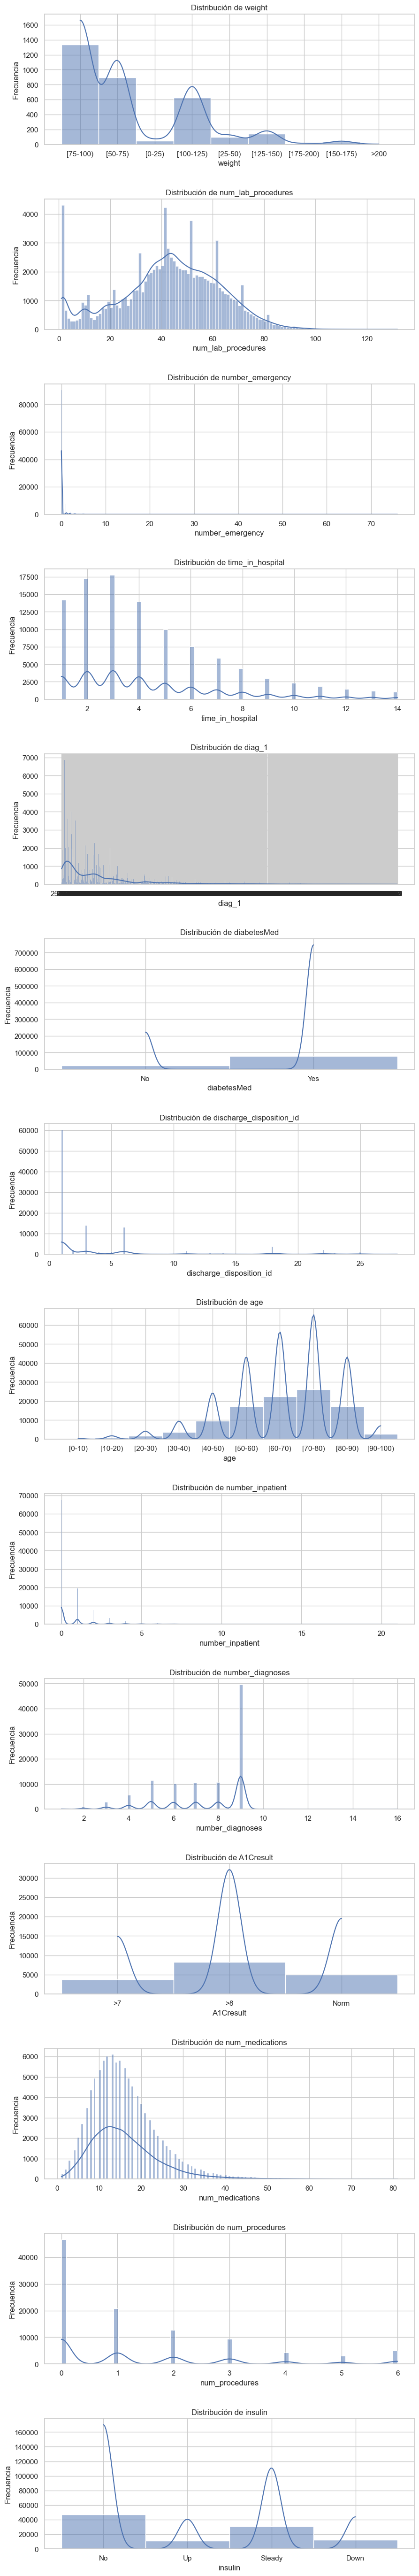

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Filtrado para iterar sobre los features
df_features = df[list(features)]

# Configuración de estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Creación de subplots
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 4 * len(features)))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(features):
    sns.histplot(df_features[feature], kde=True, ax=axes[i], palette="Set2")
    axes[i].set_title(f'Distribución de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')

plt.show()


### Analisis de las caracteristicas mas relevantes

- `number_inpatient`: Número de visitas hospitalarias (ingresos) que el paciente tuvo en el año anterior al encuentro actual.
- - Nota de datos: Es un dato numérico que indica historial previo, crucial para predecir reingresos.

- `discharge_disposition_id`: Un identificador numérico (ID) que corresponde a 29 valores distintos sobre el destino del paciente al ser dado de alta.
- - Ajuste: Se agruparon en 3 categorias que representan el mayor numero de observaciones, 1, 3 y 6 que corresponden a: 
- - - 1: Alta a domicilio
- - - 3: Traslado a hospital de segundo / tercer nivel.
- - - 6: Traslado a hospital psiquiatrico.
- `number_diagnoses`: Número total de diagnósticos ingresados en el sistema durante el encuentro.
- `number_emergency`: Número de visitas a urgencias que tuvo el paciente en el año anterior al encuentro.
- `time_in_hospital`: Entero que representa el número de días entre la admisión y el alta (duración de la estancia).
- `num_medications`: Número de nombres genéricos distintos de medicamentos administrados durante el encuentro.
- `diag_1`: El diagnóstico primario codificado con los primeros tres dígitos del código ICD-9.
- - Se agrupa en formato clinico ICD-9, que es el estandar clinico para codificar enfermedades.
- `diabetesMed`: Indica si hubo algún medicamento diabético prescrito durante el encuentro. Valores: "Yes" (Sí) o "No".
- `num_lab_procedures`: Número de pruebas de laboratorio realizadas durante el encuentro.
- - Definición: Número de pruebas de laboratorio realizadas durante el encuentro.
- `age`: Edad del paciente agrupada en intervalos de 10 años (ej. [0, 10), [10, 20), etc.).
- `num_procedures`: Número de procedimientos (distintos a pruebas de laboratorio) realizados durante el encuentro.
- `insulin`: Indica si hubo algún medicamento diabético prescrito durante el encuentro. Valores: "Yes" (Sí) o "No".
- - Indica si la droga (insulina) fue prescrita y si hubo cambio en la dosis.
- - - Valores posibles:
- - - Up: La dosis aumentó.
- - - Down: La dosis disminuyó.
- - - Steady: La dosis se mantuvo igual.
- - - No: No se prescribió la droga.

- `A1Cresult`: El resultado de la prueba de Hemoglobina Glicosilada (HbA1c).
- - Valores: >8 (mayor al 8%), >7 (mayor al 7% pero menor a 8%), normal (menor al 7%), y none (si no se midió).
- `weight`: Peso del paciente en libras.



# Ingenieria de caracteristicas
- Agrupacion en formato clinico estandar ICD9 para enfermedades.
- - Se aplicara unicamente al diangostico primario. `diag_1`
- Agrupacion en formato clinico estandar Hl7 para id de alta medica.
- 

In [43]:
df = df[list(features) + ['target']]
df.head()

,weight,num_lab_procedures,number_emergency,time_in_hospital,diag_1,diabetesMed,discharge_disposition_id,age,number_inpatient,number_diagnoses,A1Cresult,num_medications,num_procedures,insulin,target
0,NaN,41,0,1,250.83,No,25,[0-10),0,1,NaN,1,0,No,0
1,NaN,59,0,3,276,Yes,1,[10-20),0,9,NaN,18,0,Up,0
2,NaN,11,0,2,648,Yes,1,[20-30),1,6,NaN,13,5,No,0
3,NaN,44,0,2,8,Yes,1,[30-40),0,7,NaN,16,1,Up,0
4,NaN,51,0,1,197,Yes,1,[40-50),0,5,NaN,8,0,Steady,0


In [44]:
# Función auxiliar para agrupar códigos ICD-9
def map_icd9_code(code):
    if pd.isna(code): return 'Other'
    if str(code).startswith(('V', 'E')): return 'Other'
    try:
        n = float(code)
    except:
        return 'Other'
    
    if 390 <= n <= 459 or n == 785: return 'Circulatory'
    if 460 <= n <= 519 or n == 786: return 'Respiratory'
    if 520 <= n <= 579 or n == 787: return 'Digestive'
    if 250 <= n < 251: return 'Diabetes'
    if 800 <= n <= 999: return 'Injury'
    if 710 <= n <= 739: return 'Musculoskeletal'
    if 580 <= n <= 629 or n == 788: return 'Genitourinary'
    if 140 <= n <= 239: return 'Neoplasms'
    return 'Other'

# Aplicar agrupación de ICD9 a diag_1 (Diagnóstico primario es el más predictivo)
df['primary_diag_group'] = df['diag_1'].apply(map_icd9_code)
df.drop(columns=['diag_1'], inplace=True)

In [45]:
def map_discharge_id(discharge_id):
    """
    Mapea el ID de alta a una categoría descriptiva usando el estandar HL7
    """
    if discharge_id == 1:
        return 'Alta a domicilio'
    elif discharge_id == 2 or discharge_id == 3:
        return 'Traslado a un hospital de cuidados segundo y tercer nivel'
    elif discharge_id == 6:
        return 'Traslado a un hosptial psiquiatrico'
    else:
        return 'Otros'
df['discharge_category'] = df['discharge_disposition_id'].apply(map_discharge_id)
df.drop(columns=['discharge_disposition_id'], inplace=True)

### Pipeline de producción
Se asignan las variables para entrenar el modelo:
- X = Features; Las variables mas relevantes.
- y = Target; Variable objetivo.
#### La funcion del Pipeline de producción es:
- - Aplicar one hot encoding; `get_dummies` a las variables categóricas
- - Aplicar la transformación; `StandarScaler()` a las variables numéricas
- - Realizar la predicción con el modelo

In [46]:
# Separar Features y Target
X = df.drop(columns=['target']) # Usamos el grupo creado, dropeamos los crudos
y = df['target']
# Divodo la data en train y test asegurandome de configurar stratify a la data target (y).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocesadores
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Mediana es robusta a outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False para visualización fácil si se requiere
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Calculamos el ratio para balancear clases (Negativos / Positivos)
# Esto ayuda drásticamente al Recall
scale_pos_weight = (y == 0).sum() / (y == 1).sum()


#### Ajuste de hiperparametros
- Se optimiza el modelo utilizando algoritmos bayesianos con Optuna.

In [47]:
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), # Clave para desbalance
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    # Pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**params))
    ])
    
    # Validación Cruzada dentro de la optimización (Robustez)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

# Ejecuto el estudio
print("Iniciando optimización con Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True) 

print("Mejores parámetros encontrados:")
print(study.best_params)

[I 2025-12-14 09:02:19,162] A new study created in memory with name: no-name-293aa96c-239d-48f6-a2c8-bed3856d99c0


Iniciando optimización con Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-14 09:02:24,617] Trial 0 finished with value: 0.6412221610356195 and parameters: {'n_estimators': 233, 'max_depth': 4, 'learning_rate': 0.2796190856049455, 'subsample': 0.7463885350580408, 'colsample_bytree': 0.8292749315345852, 'gamma': 0.6657044314241423, 'scale_pos_weight': 1.5732828732577415}. Best is trial 0 with value: 0.6412221610356195.
[I 2025-12-14 09:02:28,213] Trial 1 finished with value: 0.6541592792518607 and parameters: {'n_estimators': 182, 'max_depth': 5, 'learning_rate': 0.14428877524811579, 'subsample': 0.8829805864512466, 'colsample_bytree': 0.779124260497419, 'gamma': 4.566922573858392, 'scale_pos_weight': 3.0201188572347055}. Best is trial 1 with value: 0.6541592792518607.
[I 2025-12-14 09:02:32,798] Trial 2 finished with value: 0.650710502231181 and parameters: {'n_estimators': 469, 'max_depth': 4, 'learning_rate': 0.2961838178033657, 'subsample': 0.8780327797375269, 'colsample_bytree': 0.6616692991198044, 'gamma': 3.1944082367469, 'scale_pos_weight': 

# Entrenamiento del modelo
- Se entrena el modelo con los mejores hiperparámetros encotrados con Optuna

In [49]:
# Entreno el mejor modelo con todos los datos de train
best_params = study.best_params
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(**best_params, random_state=42, eval_metric='logloss'))
])
best_model.fit(X_train, y_train)

# Predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

### Guardar el modelo

In [55]:
import pickle
pickle.dump(best_model, open("../models/modelo_produccion.pkl", "wb"))

# Evaluar rendimiento del modelo.

In [51]:
from sklearn.metrics import roc_auc_score, recall_score
print(f"AUC: {roc_auc_score(y_test, y_proba)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, roc_curve



# grafico auc_roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
fig_roc = go.Figure(data=[
    go.Scatter(x=fpr, y=tpr, mode='lines', name='Curva ROC (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba))),
    go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Clasificador Aleatorio')
])
fig_roc.update_layout(
    title='Curva ROC',
    xaxis_title='Tasa de Falsos Positivos (FPR)',
    yaxis_title='Tasa de Verdaderos Positivos (TPR)',
    template='plotly_white'
)
fig_roc.write_image('../reports/figures/roc_curve_optuna.png')
fig_roc.show()


AUC: 0.6654171078109835
Recall: 0.05195948921180097


# Ajuste de umbral para reducir el numero de falsos negativos
- Se ajusta el umbral del modelo para ello se

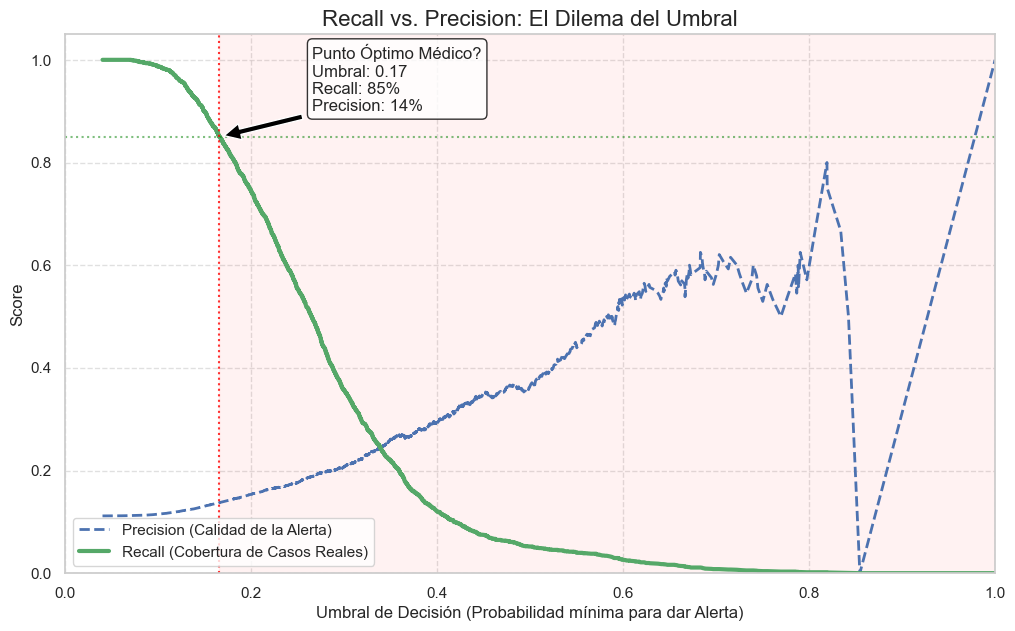

In [52]:

def plot_recall_threshold_tradeoff(y_true, y_probas):
    # Obtenemos las curvas de precisión y recall para todos los umbrales
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probas)
    
    # Ajuste de dimensiones porque 'thresholds' tiene un elemento menos
    thresholds_plot = np.append(thresholds, 1)
    
    plt.figure(figsize=(12, 7))
    
    # Ploteamos las para hacer una comparativa
    plt.plot(thresholds_plot, precisions, 'b--', label='Precision (Calidad de la Alerta)', linewidth=2)
    plt.plot(thresholds_plot, recalls, 'g-', label='Recall (Cobertura de Casos Reales)', linewidth=3)
    
    # Decoración para interpretación fácil
    plt.title('Recall vs. Precision: El Dilema del Umbral', fontsize=16)
    plt.xlabel('Umbral de Decisión (Probabilidad mínima para dar Alerta)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend(loc='lower left', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Buscamos el umbral más cercano donde Recall aprox 0.85
    target_recall = 0.85
    idx = np.argmin(np.abs(recalls - target_recall))
    ref_thresh = thresholds_plot[idx]
    ref_prec = precisions[idx]
    
    # Dibujamos líneas guía para ese punto estratégico
    plt.axvline(ref_thresh, color='red', linestyle=':', alpha=0.8)
    plt.axhline(target_recall, color='green', linestyle=':', alpha=0.5)
    
    # Anotación explicativa "Senior"
    plt.annotate(f'Punto Óptimo Médico?\nUmbral: {ref_thresh:.2f}\nRecall: {target_recall:.0%}\nPrecision: {ref_prec:.0%}',
                 xy=(ref_thresh, target_recall), 
                 xytext=(ref_thresh + 0.1, target_recall + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    # Zona de Peligro (Donde perdemos demasiados pacientes)
    plt.axvspan(ref_thresh, 1.0, color='red', alpha=0.05, label='Zona de Alto Riesgo (Bajo Recall)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.savefig('../reports/figures/recall_threshold_tradeoff.png')
    plt.show()

probs_to_plot = y_proba
        
plot_recall_threshold_tradeoff(y_test, probs_to_plot) 

--- Evaluacion del umbral optimizado (Umbral: 0.2) ---
              precision    recall  f1-score   support

           0       0.94      0.49      0.64     18083
           1       0.15      0.74      0.25      2271

    accuracy                           0.51     20354
   macro avg       0.55      0.61      0.45     20354
weighted avg       0.85      0.51      0.60     20354



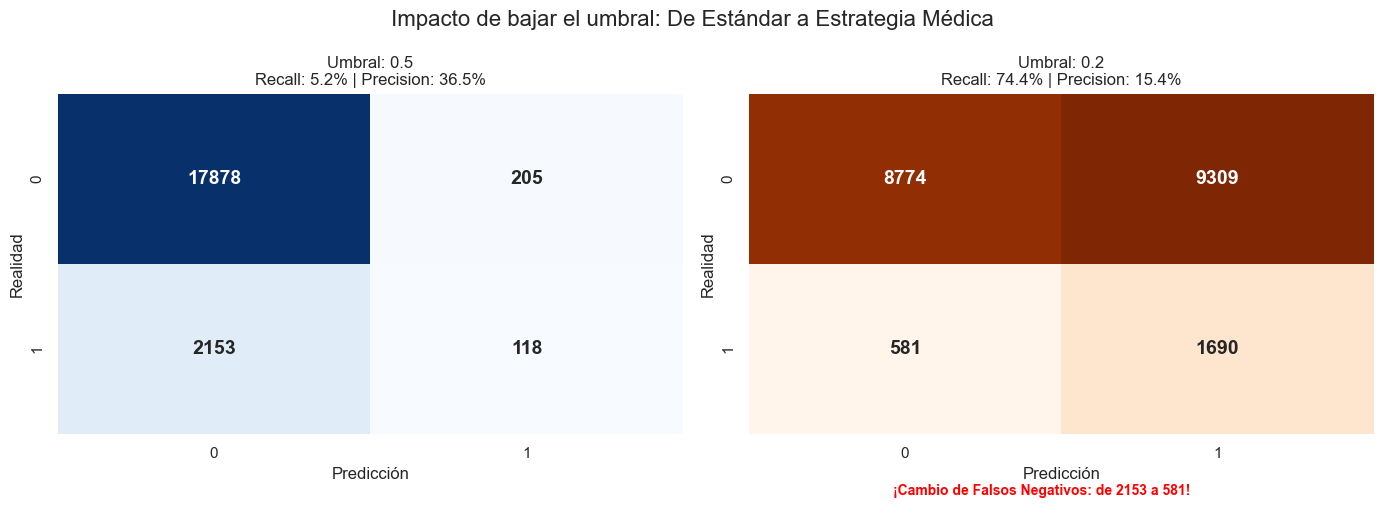

Gracias a bajar el umbral, se detectarían 1577 pacientes extra que realmente reingresaron.
Estos pacientes habrían sido ignorados con el umbral estándar.
       Probabilidad_Modelo  Prediccion_Final  Realidad
13039                0.297                 1         1
37502                0.222                 1         1
56366                0.360                 1         1
64737                0.443                 1         1
5990                 0.338                 1         1


In [53]:
# Obtener probabilidades del Test Set
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# Aplicar el umbral optimizado (.20)
THRESHOLD = 0.20
y_pred_custom = (y_proba_test >= THRESHOLD).astype(int)

# Comparativa: Umbral Default (0.5) vs Umbral Médico (0.20)
print(f"--- Evaluacion del umbral optimizado (Umbral: {THRESHOLD}) ---")
print(classification_report(y_test, y_pred_custom))

# Visualizacion comparativa del impacto del umbral
def compare_thresholds(y_true, probs, thresh_list=[0.5, 0.20]):
    plt.figure(figsize=(14, 5))
    
    for i, thresh in enumerate(thresh_list):
        plt.subplot(1, 2, i+1)
        preds = (probs >= thresh).astype(int)
        cm = confusion_matrix(y_true, preds)
        tn, fp, fn, tp = cm.ravel()
        
        # Mapa de calor
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if i==0 else 'Oranges', cbar=False,
                    annot_kws={'size': 14, 'weight': 'bold'})
        
        plt.title(f'Umbral: {thresh}\nRecall: {tp/(tp+fn):.1%} | Precision: {tp/(tp+fp):.1%}')
        plt.xlabel('Predicción')
        plt.ylabel('Realidad')
        
        # Anotación explicativa debajo
        if i == 1: # En el umbral optimizado
            plt.figtext(0.75, 0.01, f"¡Cambio de Falsos Negativos: de {confusion_matrix(y_true, (probs>=0.5).astype(int))[1,0]} a {fn}!", 
                        ha="center", fontsize=10, color="red", weight="bold")

    plt.suptitle("Impacto de bajar el umbral: De Estándar a Estrategia Médica", fontsize=16)
    plt.tight_layout()
    plt.savefig('../reports/figures/threshold_comparison.png')
    plt.show()

compare_thresholds(y_test, y_proba_test, thresh_list=[0.5, 0.20]) # 0.5 umbral estandar, .12 umbral optimizado grado clinico.

# Resultados finales: 
results_df = pd.DataFrame({
    'Probabilidad_Modelo': y_proba_test.round(3),
    'Prediccion_Final': y_pred_custom,
    'Realidad': y_test
})

# Filtramos solo los que son "Rescatados" por tu nuevo umbral
rescued_patients = results_df[
    (results_df['Probabilidad_Modelo'] >= 0.20) & 
    (results_df['Probabilidad_Modelo'] < 0.5) & 
    (results_df['Realidad'] == 1)
]

print(f"Gracias a bajar el umbral, se detectarían {len(rescued_patients)} pacientes extra que realmente reingresaron.")
print("Estos pacientes habrían sido ignorados con el umbral estándar.")
print(rescued_patients.head())

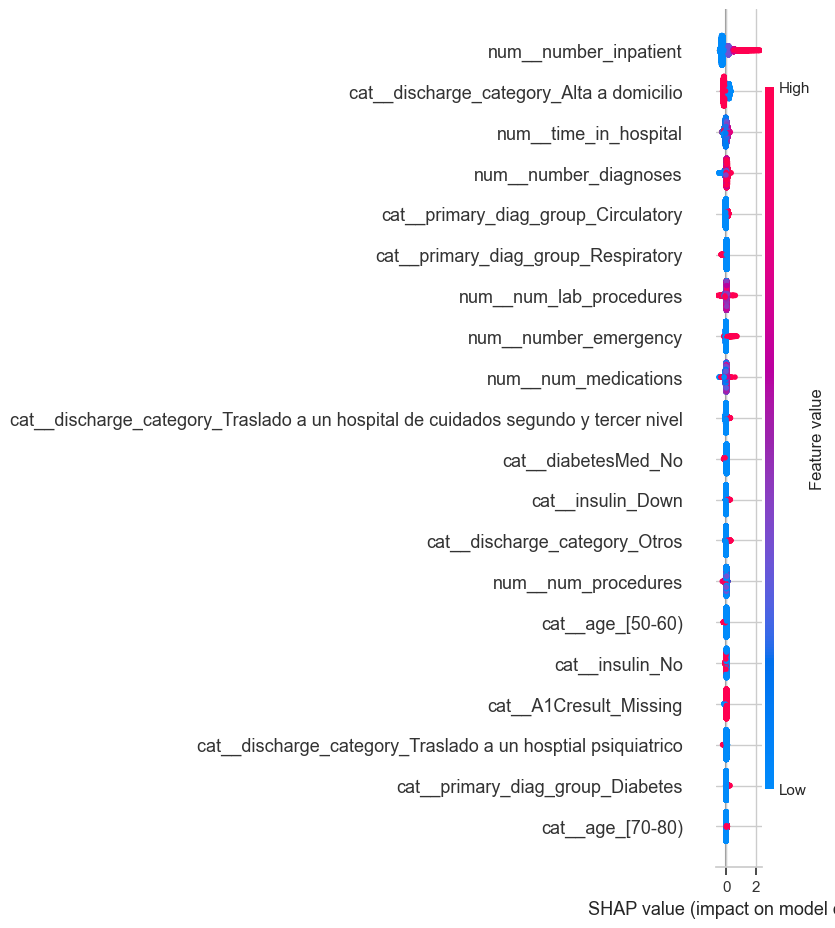

In [54]:
import shap
model_step = best_model.steps[-1][1] 
# Alternativamente, si usas scikit-learn reciente, puedes usar: best_model._final_estimator

# Transformar los datos de prueba.
preprocessor = best_model[:-1] 
X_test_transformed = preprocessor.transform(X_test)

# Crear el explainer usando el modelo extraído
explainer = shap.TreeExplainer(model_step)

# Calcular los valores SHAP usando los datos transformados
shap_values = explainer.shap_values(X_test_transformed)

if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

# Grafico utilizando shap.summary_plot funcion para evitar errores.
shap.summary_plot(shap_values, X_test_transformed)

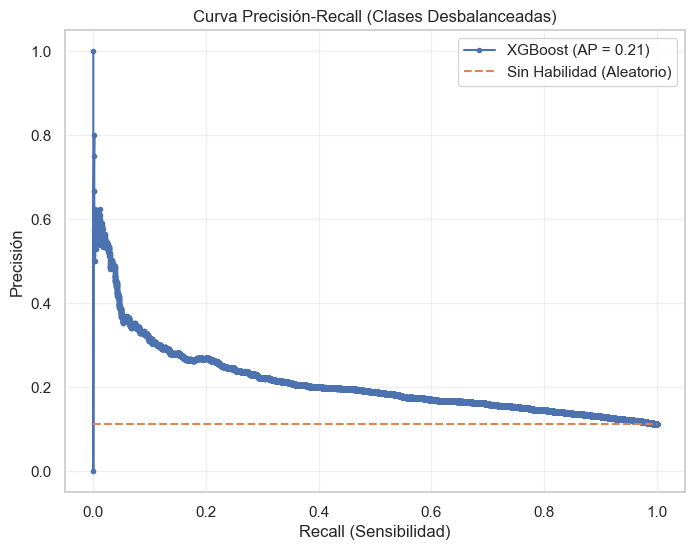

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calcular el Average Precision (AP) - El área bajo la curva PR
average_precision = average_precision_score(y_test, y_proba)

# Graficar la Curva
plt.figure(figsize=(8, 6))

# Línea del modelo
plt.plot(recall, precision, marker='.', label=f'XGBoost (AP = {average_precision:.2f})')

# Línea base ("No Skill")
# En curvas PR, la línea base es la proporción de positivos en el set de prueba
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin Habilidad (Aleatorio)')

# Etiquetas y Título
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall (Clases Desbalanceadas)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
